# **🏠 부동산 실거래가 EDA **

## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [4]:
# !pip install eli5==0.13.0

# # 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum

In [5]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [6]:
train_path = 'data/train.csv'
test_path  = 'data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [7]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [8]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [9]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [10]:
display(dt['계약년월'].min())
display(dt['계약년월'].max())

200701

202306

In [11]:
display(dt_test['계약년월'].min())
display(dt_test['계약년월'].max())

202307

202309

In [12]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [13]:
dt[['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도','도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob']]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN


In [14]:
dt[['k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형','k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적']]

,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적
0,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0
1,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0
2,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0
3,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0
4,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0
1118818,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0
1118819,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0
1118820,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0


In [15]:
dt[['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법']]

,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법
0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약
1,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약
2,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약
3,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약
4,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약
...,...,...,...,...,...,...,...,...,...,...
1118817,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약
1118818,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약
1118819,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약
1118820,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약


In [16]:
dt[['청소비관리형태','건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드','좌표X', '좌표Y', '단지신청일', 'target']]

,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000
1,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500
2,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500
3,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000
4,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000
...,...,...,...,...,...,...,...,...,...,...,...
1118817,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118818,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118819,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000
1118820,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000


### 각 컬럼별 값 확인

In [17]:
dt['시군구'].isnull().sum()

0

In [18]:
print(sorted(dt['시군구'].unique()))

['서울특별시 강남구 개포동', '서울특별시 강남구 논현동', '서울특별시 강남구 대치동', '서울특별시 강남구 도곡동', '서울특별시 강남구 삼성동', '서울특별시 강남구 세곡동', '서울특별시 강남구 수서동', '서울특별시 강남구 신사동', '서울특별시 강남구 압구정동', '서울특별시 강남구 역삼동', '서울특별시 강남구 율현동', '서울특별시 강남구 일원동', '서울특별시 강남구 자곡동', '서울특별시 강남구 청담동', '서울특별시 강동구 강일동', '서울특별시 강동구 고덕동', '서울특별시 강동구 길동', '서울특별시 강동구 둔촌동', '서울특별시 강동구 명일동', '서울특별시 강동구 상일동', '서울특별시 강동구 성내동', '서울특별시 강동구 암사동', '서울특별시 강동구 천호동', '서울특별시 강북구 미아동', '서울특별시 강북구 번동', '서울특별시 강북구 수유동', '서울특별시 강북구 우이동', '서울특별시 강서구 가양동', '서울특별시 강서구 공항동', '서울특별시 강서구 내발산동', '서울특별시 강서구 등촌동', '서울특별시 강서구 마곡동', '서울특별시 강서구 방화동', '서울특별시 강서구 염창동', '서울특별시 강서구 화곡동', '서울특별시 관악구 남현동', '서울특별시 관악구 봉천동', '서울특별시 관악구 신림동', '서울특별시 광진구 광장동', '서울특별시 광진구 구의동', '서울특별시 광진구 군자동', '서울특별시 광진구 능동', '서울특별시 광진구 자양동', '서울특별시 광진구 중곡동', '서울특별시 광진구 화양동', '서울특별시 구로구 가리봉동', '서울특별시 구로구 개봉동', '서울특별시 구로구 고척동', '서울특별시 구로구 구로동', '서울특별시 구로구 궁동', '서울특별시 구로구 신도림동', '서울특별시 구로구 오류동', '서울특별시 구로구 온수동', '서울특별시 구로구 천왕동', '서울특별시 구로구 항동', '서울특별시 금천구 가산동', '서울특별시 금천구 독산동', '서울특별시 금천구 시흥동', '서울특별시 노원구 공릉동

In [19]:
dt['번지'].isnull().sum()

225

In [20]:
x = dt['번지'].astype('str').unique()
x.sort()
print(x)
print(len(x))

['1' '1-1' '1-10' ... '산25-2' '산28-9' '산69-1']
6573


In [21]:
dt['아파트명'].isnull().sum()

2126

In [22]:
dt_apt_null = dt[dt['아파트명'].isnull()]

display(dt_apt_null['번지'].isnull().sum())
display(sorted(dt_apt_null['번지'].unique()))

0

['1-10',
 '1-102',
 '1101-1',
 '143-37',
 '1487-1',
 '149',
 '1544',
 '1546',
 '160-16',
 '1617-21',
 '185-5',
 '20-3',
 '204-11',
 '217-96',
 '23-42',
 '246-11',
 '248-7',
 '257-516',
 '323-4',
 '371-10',
 '372-66',
 '400-3',
 '404-13',
 '432-2001',
 '432-904',
 '436-79',
 '46-220',
 '60-1',
 '627-120',
 '66-3',
 '685-103',
 '716-17',
 '717-10',
 '717-39',
 '718-22',
 '718-28',
 '718-7',
 '739-19',
 '739-29',
 '739-43',
 '739-6',
 '740-11',
 '740-19',
 '740-21',
 '740-23',
 '740-24',
 '740-25',
 '740-33',
 '740-42',
 '740-56',
 '740-58',
 '740-6',
 '740-62',
 '740-7',
 '741-7',
 '742-57',
 '742-58',
 '742-64',
 '742-66',
 '742-68',
 '743-10',
 '743-14',
 '743-18',
 '743-19',
 '743-22',
 '743-26',
 '743-27',
 '743-31',
 '743-32',
 '743-33',
 '743-34',
 '743-35',
 '743-36',
 '743-37',
 '743-39',
 '743-40',
 '743-5',
 '743-52',
 '743-55',
 '743-6',
 '743-60',
 '743-72',
 '743-8',
 '744-13',
 '744-14',
 '744-15',
 '744-16',
 '744-18',
 '744-19',
 '744-21',
 '744-23',
 '744-3',
 '744-45',


In [23]:
display(dt['도로명'].isnull().sum())
display(sorted(dt['도로명'].unique()))

0

[' ',
 ' 10',
 ' 174-2',
 ' 18',
 ' 20',
 ' 20-3',
 ' 21-9',
 ' 210',
 ' 232',
 ' 245',
 ' 260',
 ' 27',
 ' 287-19',
 ' 295',
 ' 298',
 ' 30',
 ' 348',
 ' 35-28',
 ' 37',
 ' 38',
 ' 43',
 ' 5',
 ' 50',
 ' 55',
 ' 62',
 ' 64',
 '4.19로 19-10',
 '4.19로11길 16',
 '4.19로1길 33',
 '4.19로9길 17',
 '4.19로9길 18',
 '63로 32',
 '63로 36',
 '63로 45',
 '63로 7',
 '가락로 165',
 '가락로 187',
 '가락로 192',
 '가락로 232',
 '가락로31길 19',
 '가락로34길 5-25',
 '가락로36길 5-14',
 '가락로36길 5-20',
 '가락로36길 5-24',
 '가락로36길 5-8',
 '가락로36길 9-21',
 '가락로38길 10',
 '가락로39길 5',
 '가락로3길 3-11',
 '가락로3길 3-16',
 '가락로3길 3-20',
 '가락로3길 3-24',
 '가락로5길 4-26',
 '가로공원로 129',
 '가로공원로 177-3',
 '가로공원로 221',
 '가로공원로 224',
 '가로공원로 233',
 '가로공원로 78',
 '가로공원로 82',
 '가로공원로 83',
 '가로공원로56길 10',
 '가로공원로61길 20',
 '가로공원로64길 13',
 '가로공원로77길 21',
 '가로공원로77길 25',
 '가로공원로77길 27',
 '가마산로 231',
 '가마산로 268',
 '가마산로 271',
 '가마산로 280',
 '가마산로 283',
 '가마산로 284',
 '가마산로 285',
 '가마산로 286',
 '가마산로 312',
 '가마산로 315',
 '가마산로 426',
 '가마산로 442',
 '가마산로 468',
 '가마산로 575',
 '가마산로

In [24]:
# 무슨 해제일까??
display(dt[dt['해제사유발생일'].isnull() == False])
display(len(dt[dt['해제사유발생일'].isnull() == False]))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
201044,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,59.9670,202304,18,22,2019,...,16155.05,3153.0,의무,2019-03-14 11:33:30.0,Y,N,127.064151,37.480049,2019-03-09 05:56:52.0,185000
201047,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,84.9400,202304,26,26,2019,...,16155.05,3153.0,의무,2019-03-14 11:33:30.0,Y,N,127.064151,37.480049,2019-03-09 05:56:52.0,249500
201050,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,59.9670,202305,8,16,2019,...,16155.05,3153.0,의무,2019-03-14 11:33:30.0,Y,N,127.064151,37.480049,2019-03-09 05:56:52.0,190000
201079,서울특별시 강남구 대치동,1014-3,1014.0,3.0,대치삼성,84.5800,202306,2,8,2000,...,8414.21,1238.0,의무,2013-06-23 14:22:18.0,Y,N,127.058356,37.496336,2013-03-07 09:46:34.0,220000
201083,서울특별시 강남구 대치동,1014-3,1014.0,3.0,대치삼성,97.3500,202306,3,4,2000,...,8414.21,1238.0,의무,2013-06-23 14:22:18.0,Y,N,127.058356,37.496336,2013-03-07 09:46:34.0,240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395968,서울특별시 동작구 사당동,1159,1159.0,0.0,래미안로이파크,84.9800,202007,13,18,2018,...,4902.75,873.0,의무,2018-10-29 10:06:29.0,Y,N,126.974222,37.487543,2018-05-16 11:44:43.0,150000
395994,서울특별시 동작구 상도동,536,536.0,0.0,상도효성해링턴플레이스,84.9506,202007,9,7,2016,...,1343.61,203.0,임의,2019-07-25 09:01:41.0,Y,N,126.942149,37.505792,2017-02-10 12:21:22.0,110000
396268,서울특별시 성북구 돈암동,1,1.0,0.0,돈암현대,41.5800,202007,23,3,1991,...,0.00,375.0,의무,2015-10-12 14:31:48.0,Y,N,127.028589,37.604127,2013-03-07 09:47:01.0,38000
396289,서울특별시 송파구 장지동,844,844.0,0.0,송파파인타운7단지,84.9400,202006,8,14,2007,...,0.00,576.0,의무,2019-02-22 15:31:58.0,Y,N,127.130827,37.479157,2013-03-07 09:46:51.0,107000


5983

In [25]:
display(dt['해제사유발생일'].isnull().sum())
display(dt['해제사유발생일'].unique())


1112839

array([      nan, 20230515., 20230614., ..., 20200613., 20200509.,
       20221125.])

In [26]:
x = dt['등기신청일자'].unique()
x.sort()
display(x)

display(len(dt[dt['등기신청일자'] == ' ']))

array([' ', '20230102', '20230104', '20230105', '20230109', '20230110',
       '20230111', '20230112', '20230113', '20230116', '20230117',
       '20230118', '20230119', '20230120', '20230125', '20230126',
       '20230127', '20230130', '20230131', '20230201', '20230202',
       '20230203', '20230206', '20230207', '20230208', '20230209',
       '20230210', '20230213', '20230214', '20230215', '20230216',
       '20230217', '20230220', '20230221', '20230222', '20230223',
       '20230224', '20230227', '20230228', '20230302', '20230303',
       '20230306', '20230307', '20230308', '20230309', '20230310',
       '20230313', '20230314', '20230315', '20230316', '20230317',
       '20230320', '20230321', '20230322', '20230323', '20230324',
       '20230327', '20230328', '20230329', '20230330', '20230331',
       '20230403', '20230404', '20230405', '20230406', '20230407',
       '20230410', '20230411', '20230412', '20230413', '20230414',
       '20230417', '20230418', '20230419', '20230420', '2

1103907

In [27]:
pd.notnull(' ')

True

In [28]:
display(dt['거래유형'].unique())
display(len(dt[dt['거래유형'] == '-']))

array(['-', '중개거래', '직거래'], dtype=object)

1086451

In [29]:
display(dt['중개사소재지'].unique())
display(len(dt[dt['중개사소재지'] == '-']))

array(['-', '서울 강남구, 서울 송파구', '서울 강남구', '서울 강남구, 서울 마포구',
       '서울 강남구, 서울 서초구', '서울 강남구, 인천 연수구', '서울 영등포구', '서울 동작구',
       '경기 성남분당구, 서울 강남구', '서울 강남구, 서울 동대문구', '대구 중구, 서울 강남구',
       '경기 수원영통구, 서울 강남구', '경기 수원팔달구, 서울 강남구', '서울 강남구, 서울 종로구',
       '서울 강남구, 인천 서구', '경기 과천시, 서울 강남구', '서울 서초구', '서울 강남구, 충남 천안서북구',
       '서울 강남구, 서울 용산구', '경기 안양동안구, 서울 강남구', '서울 강남구, 서울 강동구',
       '서울 강남구, 서울 금천구', '서울 강남구, 서울 영등포구', '서울 강남구, 서울 동작구',
       '경기 시흥시, 서울 강남구', '서울 강동구', '경기 하남시', '경기 하남시, 서울 강동구',
       '서울 강동구, 서울 서초구', '인천 서구', '대구 달성군, 서울 강동구', '서울 강동구, 서울 송파구',
       '서울 강동구, 서울 서대문구', '서울 강동구, 서울 성동구', '서울 강동구, 서울 성북구',
       '서울 강동구, 서울 용산구', '경기 화성시, 서울 강남구', '서울 강남구, 서울 강서구',
       '서울 강남구, 서울 광진구', '서울 송파구', '경기 하남시, 서울 송파구', '경기 용인수지구',
       '경기 성남분당구', '경기 성남수정구, 서울 송파구', '서울 강남구, 서울 성동구', '서울 용산구',
       '서울 강남구, 서울 성북구', '경기 남양주시, 서울 강동구', '서울 동대문구', '서울 강동구, 서울 마포구',
       '서울 강동구, 서울 동대문구', '서울 강동구, 서울 동작구', '경기 성남수정구, 서울 강동구',
       '서울 강동구, 충북 청주흥덕구', '

1089581

In [30]:
display(dt['k-단지분류(아파트,주상복합등등)'].isnull().sum())

display(dt['k-단지분류(아파트,주상복합등등)'].unique())

870691

array(['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)'],
      dtype=object)

In [31]:
dt[dt['k-단지분류(아파트,주상복합등등)'].isnull()]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
417,서울특별시 강남구 대치동,988-4,988.0,4.0,대치효성,59.84,201710,27,17,1999,...,0.0,86.0,의무,2022-04-13 14:28:19.0,Y,N,127.061209,37.499906,2022-04-12 19:10:56.0,79000
418,서울특별시 강남구 대치동,988-4,988.0,4.0,대치효성,84.94,201710,30,13,1999,...,0.0,86.0,의무,2022-04-13 14:28:19.0,Y,N,127.061209,37.499906,2022-04-12 19:10:56.0,100700
419,서울특별시 강남구 대치동,988-4,988.0,4.0,대치효성,84.91,201806,29,9,1999,...,0.0,86.0,의무,2022-04-13 14:28:19.0,Y,N,127.061209,37.499906,2022-04-12 19:10:56.0,118000
975,서울특별시 강남구 개포동,189,189.0,0.0,개포주공4단지,50.39,201801,25,1,1982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134000
976,서울특별시 강남구 개포동,189,189.0,0.0,개포주공4단지,50.39,201801,25,4,1982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118203,서울특별시 중랑구 중화동,274-77,274.0,77.0,한영,70.96,200709,6,4,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17000
1118204,서울특별시 중랑구 중화동,11,11.0,0.0,현대휴앤미,100.17,200704,23,2,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
1118205,서울특별시 중랑구 중화동,11,11.0,0.0,현대휴앤미,95.94,200704,26,3,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27000
1118206,서울특별시 중랑구 중화동,11,11.0,0.0,현대휴앤미,100.20,200705,19,6,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24200


In [32]:
dt['k-전화번호']

0            025776611
1            025776611
2            025776611
3            025776611
4            025776611
              ...     
1118817     23547358.0
1118818     23547358.0
1118819     23547358.0
1118820     23547358.0
1118821    222722129.0
Name: k-전화번호, Length: 1118822, dtype: object

In [33]:
dt['k-팩스번호']

0            025776673
1            025776673
2            025776673
3            025776673
4            025776673
              ...     
1118817     23529429.0
1118818     23529429.0
1118819     23529429.0
1118820     23529429.0
1118821    222723129.0
Name: k-팩스번호, Length: 1118822, dtype: object

In [34]:
display(dt['단지소개기존clob'].isnull().sum())
display(dt[dt['단지소개기존clob'].isnull() == False]['단지소개기존clob'])

1050240

12         2888.0
13         2888.0
14         2888.0
15         2888.0
16         2888.0
            ...  
1118779     397.0
1118780     397.0
1118781     397.0
1118782     397.0
1118783      93.0
Name: 단지소개기존clob, Length: 68582, dtype: float64

In [35]:
display(dt['k-세대타입(분양형태)'].isnull().sum())
display(dt['k-세대타입(분양형태)'].unique())

869563

array(['분양', '기타', nan, '임대'], dtype=object)

In [36]:
display(dt['k-관리방식'].isnull().sum())
display(dt['k-관리방식'].unique())

869563

array(['자치관리', '위탁관리', '직영', nan], dtype=object)

In [37]:
display(dt['k-복도유형'].isnull().sum())
display(dt['k-복도유형'].unique())

869890

array(['계단식', '혼합식', '복도식', '타워형', '기타', nan], dtype=object)

In [38]:
display(dt['k-난방방식'].isnull().sum())
display(dt['k-난방방식'].unique())

869563

array(['개별난방', '지역난방', '기타', nan, '중앙난방'], dtype=object)

In [39]:
display(dt['k-전체동수'].isnull().sum())
display(dt['k-전체동수'].unique())

870630

array([  8.,   5.,   4., 124.,   6.,   9.,   1.,  14.,  nan,  34.,   2.,
        11.,  28.,  15.,   7.,  12.,  16.,   3.,  19.,  10.,  26.,  20.,
        13.,  22.,  41.,  40.,  37.,  21.,  50.,  23.,  18.,  32.,  24.,
        31.,  17.,  33.,  51.,  44.,  30.,  56.,  72.,  84.])

In [40]:
display(dt['k-전체세대수'].isnull().sum())
display(dt['k-전체세대수'].unique())

869563

array([ 270.,  405.,  212., 5040.,  940., 1060.,  203.,  260.,  368.,
        960.,  630.,   83.,  354.,  144.,  372., 3002.,  384.,  390.,
        397.,  768., 4424.,   nan,  132.,   59.,  416.,  298.,  114.,
        546.,  395.,  410.,  809.,  912.,  787.,  498.,  139.,   86.,
        464.,  117., 1050.,  408.,  738.,  294.,  137.,  364.,  570.,
        716., 1304., 1020., 1070.,  391.,  240.,  888.,  108.,  708.,
        317.,  694.,  282.,  442.,  987.,  722.,  553.,  731.,  841.,
        605.,  740.,  748.,  636.,  207.,  800.,  232.,  772., 2283.,
        687.,  222.,  151., 1622.,  230.,   74.,  225.,  999.,  150.,
        615.,  480., 1585.,  376.,  216.,  380.,  261.,  430., 1624.,
       1476.,  642.,  414.,  790.,  990., 1421.,  629.,  518.,  919.,
        399.,  643., 2198.,  948.,  200.,  180.,  347.,  237.,  315.,
        420.,  439., 1004.,  170.,  284.,  320.,  930.,  209.,  341.,
        202.,  187.,  680.,  417.,  152.,  178.,  163.,  127., 2603.,
        159., 1164.,

In [41]:
display(dt['k-건설사(시공사)'].isnull().sum())
display(dt['k-건설사(시공사)'].unique())

871058

array(['우성건설', '박연정', '대한주택공사', '현대건설(주)', '동양고속건설주식회사', '대우건설',
       '대림산업(주)', '삼성물산', nan, '삼성물산주식회사', '현대,쌍용,GS', '쌍용건설(주)',
       '현대산업개발', '한보', '삼성중공업', '대성산업', '중앙건설', '세방기업', '태영건설', '신동아',
       '신동아건설', '고려개발(주)', '대우건설,대림산업,태영건설', '한라, 두진', '고려산업개발(주)',
       '삼성건설', '롯데건설', 'GS건설', '(주)한화건설', '한신공영', '(주)건영,삼익주택,라이프주택',
       '계룡건설산업(주)', '한양수자인', '건영종합건설(주)', '청담삼익아파트', '계룡건설(주)', '삼환기업',
       '한신공영(주)', 'KR산업', '동부건설', '고속도로관리공단', '동부건설(주)외1', 'SH공사',
       '남광, 대우', 'sh공사', '청광종합건설(주)', '중앙건설(주)', 'LG건설', '신동아건설(주)',
       '현대산업개발(주)', '(주)청구주택', '삼호건설', '(주)삼호', '한솔건설', '현대,대림',
       '신동아 건설(주)', '임광토건(주)', '롯데건설(주)', '벽산건설', '동부건설(주)', '현대 성우건설',
       '홍익종합건업(주)', '한양주택 (주)', '한진중공업(주)', '성지건설', '남광토건(주)', 'gs건설',
       '신명건설,신원건설,미주건설', 'KCC', '두산, 이수건설', '두산건설', 'TEC건설',
       '현대건설,현대산업개발,한진중공업', '성원건설(주)', '라인건설', '코오롱글로벌(주)', '금호건설',
       '(주)대보건설', '(주)한양', '경남기업', '에스에이치공사', '금호', '(주)서광건설산업',
       '우림건설(주)', '중앙하이츠', '청구', '우림건설', '삼환, 삼익건설

In [42]:
display(dt['k-시행사'].isnull().sum())
display(dt['k-시행사'].unique())

871254

array(['모름', '우성건설', 'LG건설', '대한주택공사', '대우건설', '동양고속건설주식회사',
       '경복아파트주택재건축정비사업조합', '삼성물산', '신해청재건축조합', nan, '우성2차리모델링주택조합',
       '프리즘(주)', '도곡주공재건축조합', '도곡동신아파트리모델링주택조합', '을지조합', '대치도곡제2아파트재건축조합',
       '한보', '도곡연합주택조합', '대성산업', '상아3차아파트주택재건축정비사업조합', '중앙건설', 'SH공사',
       'sh공사', 'sh 공사', '한국토지주택공사', 'LH강남지역본부', '한라, 두진',
       '신사동 한영아파트 1지구 재건축조합', '삼성건설', '롯데건설', '영동1재건축조합',
       '개나리6차아파트주택재건축정비사업조합', '.', '(주)한화건설', '한신공영',
       '건영종합건설, 삼익주택,라이프주택', '청강연합주택조합', '청담삼익아파트', '현대산업개발',
       '청담 한양아파트 주택재건축사업조합', '현대건설(주)', '에스에이치공사', '서울주택도시공사', '남광토건, 대우',
       '청광종합건설(주)', '길동진흥아파트주택재건축정비사업조합', '청수연립재건축조합', '명일시영아파트 재건축조합',
       '고덕주공4단지주택재건축정비사업조합', '둔촌역지역주택조합', '삼호건설', '대농연립재건축조합', '샘하우징',
       '현대,대림', '(주)포유', '(주)디씨엠하우징', '생보부동산신탁', '미아제4구역재개발정비사업조합',
       '미아제10구역주택재개발조합', '미아1-2재개발조합', '미아10-1구역재개발조합', '양지연립주택조함',
       '건정종합건축사사무소', '번동한양아파트주택조합', '대한주택보증(주)', 'SH도시개발공사', 'SH 공사',
       '가양동 현대연합주택조합', '화이트코리아(주식회사)', '신명건설,신원건설,미주건설', 'TEC건설',
   

In [43]:
display(dt['k-사용검사일-사용승인일'].isnull().sum())
display(dt['k-사용검사일-사용승인일'].unique())

869696

array(['1987-11-21 00:00:00.0', '1984-12-31 00:00:00.0',
       '2004-06-17 00:00:00.0', '1982-06-04 00:00:00.0',
       '1983-10-26 00:00:00.0', '2004-06-02 00:00:00.0',
       '2004-11-26 00:00:00.0', '2014-12-08 00:00:00.0',
       '2000-07-31 00:00:00.0', '1999-06-14 00:00:00.0', nan,
       '1989-12-06 00:00:00.0', '2008-02-22 00:00:00.0',
       '2004-04-29 00:00:00.0', '2006-01-27 00:00:00.0',
       '1978-12-26 00:00:00.0', '1986-10-31 00:00:00.0',
       '2016-09-02 00:00:00.0', '2008-06-03 00:00:00.0',
       '1979-08-30 00:00:00.0', '1999-01-06 00:00:00.0',
       '2004-07-01 00:00:00.0', '2018-03-30 00:00:00.0',
       '2004-12-29 00:00:00.0', '2001-12-17 00:00:00.0',
       '2011-11-01 00:00:00.0', '2011-02-23 00:00:00.0',
       '2013-06-12 00:00:00.0', '2012-08-31 00:00:00.0',
       '2014-08-05 00:00:00.0', '1993-11-01 00:00:00.0',
       '1998-11-16 00:00:00.0', '2004-04-20 00:00:00.0',
       '2010-06-04 00:00:00.0', '2007-02-26 00:00:00.0',
       '2005-10-26 00:00:0

In [44]:
display(dt['k-연면적'].isnull().sum())
display(dt['k-연면적'].unique())

869563

array([2.263700e+04, 6.330400e+04, 6.035900e+04, 2.406290e+05,
       9.381000e+04, 9.481700e+04, 7.029100e+04, 2.124400e+04,
       7.481200e+04, 1.425070e+05, 9.140100e+04, 0.000000e+00,
       6.900900e+04, 2.485000e+04, 5.536610e+05, 7.727000e+04,
       4.031100e+04, 6.738000e+04, 1.474420e+05, 5.046980e+05,
                nan, 1.494300e+04, 8.502000e+03, 7.410200e+04,
       6.373300e+04, 2.419300e+04, 1.016330e+05, 4.631800e+04,
       5.523300e+04, 1.170750e+05, 1.333460e+05, 1.254590e+05,
       8.643400e+04, 2.395000e+04, 3.135500e+04, 7.789400e+04,
       3.745300e+04, 1.307010e+05, 7.456000e+04, 9.936300e+04,
       2.692400e+04, 4.231500e+04, 6.607600e+04, 1.029880e+05,
       2.017930e+05, 1.913000e+05, 1.453230e+05, 6.472100e+04,
       3.050900e+04, 1.178830e+05, 2.080800e+04, 1.028090e+05,
       5.223000e+04, 9.410000e+04, 3.753000e+04, 6.545200e+04,
       1.123660e+05, 8.426200e+04, 6.352400e+04, 8.075300e+04,
       5.288000e+04, 1.101160e+05, 8.516900e+04, 8.2830

In [45]:
display(dt['k-주거전용면적'].isnull().sum())
display(dt['k-주거전용면적'].unique())

869608

array([ 20204.,  53437.,  32275., 242461.,  65960.,  73333.,  35547.,
         9435.,  33280.,  83135.,  49313.,   6190.,  39078.,  17437.,
        15149., 298679.,  42932.,  32577.,  33275.,  78559., 353089.,
           nan,   9523.,   4932.,  34877.,  33866.,  52989.,  20412.,
        26461.,  58941.,  70586.,  63104.,  59106.,  10759.,  17300.,
        42335.,  20123.,  69466.,  36394.,  53254.,  12172.,  22011.,
        35785.,  45360.,  52663., 100993.,  99131.,  71732.,  36462.,
        20303., 108244.,  11897.,  47130.,  27849.,  54671.,  20746.,
        39375.,  58114.,  44692.,  35283.,  41058.,  28122.,  63052.,
        44851.,  57866.,  49047.,  46910.,   2770.,  66945.,  17712.,
        57750., 166321.,  52861.,  15902.,  18852.,  13446.,  18089.,
       140765.,  23244.,   6163.,  19118.,  79937.,  13829.,  45906.,
        36746., 130871.,  26707.,  14934.,  26895.,  22099.,  36325.,
        66817.,  72903.,  45932.,  34626.,  73129.,  84140.,  82603.,
        46505.,  438

In [46]:
display(dt['k-관리비부과면적'].isnull().sum())
display(dt['k-관리비부과면적'].unique())

869563

array([ 22637.,  61064.,  38614., 240629.,  65960.,  94578.,  42833.,
        12033.,  33208.,  83159.,  67052.,      0.,  50475.,  19812.,
       379722.,  52285.,  39792.,  43122.,  99276., 470732.,     nan,
        14790., 361341.,  46757.,  42856., 116515.,  67648.,  29695.,
        36348., 116860., 132902.,  86240.,  71711.,  10759.,  22015.,
        55307.,  23289.,  69466.,  51178.,  67654.,  12193.,  38678.,
        54686., 102814., 136339., 191300., 101020.,  45779.,  30506.,
       117691.,  14796.,  63868.,  37369.,  54671.,  27640.,  50744.,
        80038.,  61838.,  47777.,  55097.,  38876.,  83887.,  59910.,
        70616.,  67347.,  46334.,   4947.,  87978.,  24629., 100105.,
       219853.,  71361.,  21283.,  23207.,  22218.,  22466., 181847.,
        31040.,  25588., 114090.,  17087.,  59451.,  46592., 167527.,
        34584.,  20948.,  35286.,  22099.,  46951.,  97259., 104811.,
        60210.,  41891.,  96610., 103089., 108117.,  59793.,  56412.,
        82577.,  333

In [47]:
display(dt['k-전용면적별세대현황(60㎡이하)'].isnull().sum())
display(dt['k-전용면적별세대현황(60㎡이하)'].unique())

869608

array([2.000e+01, 0.000e+00, 4.975e+03, 1.900e+02, 2.200e+02, 2.600e+02,
       3.400e+01, 2.490e+02, 2.860e+02, 3.440e+02, 6.010e+02, 8.100e+01,
       1.500e+02,       nan, 6.600e+01, 1.150e+02, 6.000e+01, 4.400e+01,
       3.950e+02, 2.750e+02, 3.240e+02, 1.670e+02, 2.970e+02, 4.800e+01,
       9.400e+01, 7.220e+02, 1.040e+02, 3.760e+02, 2.940e+02, 1.950e+02,
       6.250e+02, 7.140e+02, 7.500e+01, 3.880e+02, 1.010e+02, 3.220e+02,
       1.260e+02, 4.600e+01, 7.310e+02, 5.140e+02, 2.950e+02, 5.150e+02,
       2.060e+02, 4.610e+02, 2.960e+02, 4.180e+02, 3.540e+02, 2.070e+02,
       1.790e+02, 1.170e+02, 3.100e+02, 1.237e+03, 2.580e+02, 1.180e+02,
       3.280e+02, 2.000e+00, 2.310e+02, 2.050e+02, 1.920e+02, 5.760e+02,
       1.840e+02, 1.280e+02, 2.120e+02, 1.400e+02, 1.624e+03, 1.476e+03,
       3.420e+02, 8.410e+02, 2.720e+02, 6.720e+02, 2.370e+02, 9.480e+02,
       1.690e+02, 7.400e+01, 1.300e+02, 1.830e+02, 1.530e+02, 1.030e+02,
       1.910e+02, 9.600e+01, 1.750e+02, 9.300e+02, 

In [48]:
display(dt['k-전용면적별세대현황(60㎡~85㎡이하)'].isnull().sum())
display(dt['k-전용면적별세대현황(60㎡~85㎡이하)'].unique())

869608

array([2.500e+02, 0.000e+00, 6.500e+01, 7.500e+02, 8.400e+02, 2.220e+02,
       1.920e+02, 2.030e+02, 4.900e+01, 2.800e+01, 9.360e+02, 4.800e+01,
       3.900e+02, 1.590e+02, 2.380e+02, 4.424e+03,       nan, 6.600e+01,
       5.900e+01, 2.040e+02, 9.000e+01, 2.430e+02, 1.350e+02, 4.850e+02,
       7.450e+02, 3.400e+02, 2.700e+01, 1.880e+02, 3.280e+02, 1.560e+02,
       3.620e+02, 1.340e+02, 5.700e+02, 5.210e+02, 3.470e+02, 3.060e+02,
       8.600e+01, 2.400e+02, 1.160e+02, 7.600e+01, 2.140e+02, 2.940e+02,
       2.560e+02, 2.080e+02, 2.580e+02, 2.160e+02, 1.700e+02, 2.300e+02,
       7.400e+02, 3.300e+02, 5.000e+02, 8.200e+01, 4.620e+02, 7.520e+02,
       3.870e+02, 1.040e+02, 1.530e+02, 1.260e+02, 1.650e+02, 9.140e+02,
       7.200e+01, 2.250e+02, 7.560e+02, 9.800e+01, 3.860e+02, 2.620e+02,
       6.480e+02, 1.490e+02, 8.800e+01, 1.680e+02, 2.610e+02, 2.120e+02,
       3.000e+02, 4.140e+02, 2.820e+02, 9.900e+02, 5.800e+02, 3.570e+02,
       5.180e+02, 2.470e+02, 1.620e+02, 2.480e+02, 

In [49]:
display(dt['k-85㎡~135㎡이하'].isnull().sum())
display(dt['k-85㎡~135㎡이하'].unique())

869608

array([0.000e+00, 2.850e+02, 8.400e+01, 1.120e+02, 5.190e+02, 1.410e+02,
       3.540e+02, 1.440e+02, 1.402e+03, 2.880e+02, 1.570e+02, 2.360e+02,
             nan, 7.500e+01, 2.590e+02, 1.500e+02, 4.380e+02, 6.400e+01,
       1.820e+02, 1.480e+02, 2.300e+02, 3.320e+02, 1.020e+03, 5.000e+01,
       5.760e+02, 1.080e+02, 2.040e+02, 1.400e+02, 1.580e+02, 1.020e+02,
       2.100e+02, 7.900e+01, 9.400e+01, 1.210e+02, 3.300e+01, 2.940e+02,
       4.200e+01, 2.500e+01, 3.800e+01, 3.800e+02, 5.200e+01, 2.400e+01,
       2.600e+01, 3.610e+02, 4.300e+01, 7.800e+01, 3.040e+02, 6.060e+02,
       4.000e+01, 3.000e+01, 9.600e+01, 9.000e+01, 1.990e+02, 4.880e+02,
       6.600e+01, 1.500e+01, 2.300e+01, 6.800e+02, 5.800e+01, 8.430e+02,
       9.900e+01, 3.450e+02, 4.100e+01, 9.500e+01, 9.140e+02, 1.800e+01,
       7.100e+01, 1.180e+02, 6.300e+01, 2.200e+01, 8.900e+01, 2.800e+01,
       3.500e+02, 6.000e+02, 1.750e+02, 7.000e+01, 4.600e+01, 4.700e+01,
       6.200e+01, 9.200e+01, 1.040e+02, 1.360e+02, 

In [50]:
display(dt['k-135㎡초과'].isnull().sum())
display(dt['k-135㎡초과'].unique())

1118495

array([nan, 70.])

In [51]:
display(dt['k-홈페이지'].isnull().sum())
display(dt['k-홈페이지'].unique())

1005647

array([nan, 'test', 'gaepo001@naver.com', '대치삼성.apti.co.kr',
       '대치현대.apti.co.kr', 'www.rexleapt.com', '세곡리엔파크1단지.apti.co.kr/',
       '강남신동아파밀리에2단지.apti.co.kr', 'https://sgprugio.aptner.com/',
       'www..openapt.seoul.go.kr', '없음', '래미안강남힐즈.apti.co.kr',
       'scdp.co.kr', 'cdsi.apti.co.kr', 'WWW.청담자이.APTi.CO.KR',
       '강일리버파크2단지.apti.co.kr/', 'intm.com/강일리버파크8단지', 'k-apt.co.kr',
       '강일리버파크4단지.okhomeapt.co.kr', '고덕리엔파크2단지', 'www.milgapt.com',
       'www.고덕리엔파크3단지.apti.co.kr', 'gdsipark.apti.co.k',
       'www.priorpalace.net', 'home.drapt.com/choi9302',
       'cafe.daum.net/BSLP', 'cafe.daum.net/songcheoncentreville',
       'http://www.ghxi.kr/', 'wjshill.com', 'cafe.daum.net/o2vill3',
       '방화2차우림루미아트.apti.co.kr/', 'cafe.daum.net/banghwa12/4xuQ',
       'magokprugio.com', 'cafe.daum.net/yctheheim', '강서힐스테이트.apti.co.kr',
       'www.lottecastle1145.co.kr', 'www.', '화곡푸르지오.apti.co.kr',
       '남현한일유엔아이.apt.co.kr', 'www.kaprugio.com', '신림현대.apti.co.kr',
       'cafe.da

In [52]:
display(dt['k-등록일자'].isnull().sum())
display(dt['k-등록일자'].unique())

1107832

array(['2022-11-09 20:10:43.0', nan, '2017-04-18 04:58:55.0',
       '2020-07-10 08:13:08.0', '2020-07-15 11:52:12.0',
       '2021-02-18 10:00:38.0', '2018-05-09 09:48:21.0',
       '2020-07-10 08:13:13.0', '2017-02-01 10:49:21.0',
       '2020-07-10 08:05:08.0', '2020-07-08 07:58:37.0',
       '2019-10-03 07:20:13.0', '2018-04-01 20:01:53.0',
       '2017-04-18 06:09:55.0', '2017-09-06 06:35:46.0',
       '2017-07-11 22:35:21.0', '2020-09-09 08:41:56.0',
       '2017-11-17 04:30:09.0', '2020-10-08 09:24:25.0',
       '2020-08-01 04:34:20.0', '2022-12-30 13:37:10.0',
       '2017-04-17 23:07:51.0', '2020-09-25 06:05:36.0',
       '2017-04-17 21:15:43.0', '2018-08-28 21:22:34.0',
       '2018-06-25 21:14:05.0', '2023-05-12 10:09:44.0',
       '2020-07-29 10:46:46.0', '2017-08-23 03:47:00.0',
       '2020-07-09 06:08:21.0', '2017-04-18 00:18:26.0',
       '2017-02-10 12:21:22.0', '2018-09-21 01:57:13.0',
       '2017-05-25 04:14:35.0', '2017-07-14 05:20:39.0',
       '2018-11-02 01:31:0

In [53]:
display(dt['k-수정일자'].isnull().sum())
display(dt['k-수정일자'].unique())

869608

array(['2023-09-23 17:21:41.0', '2023-09-23 17:15:43.0',
       '2023-09-23 17:17:38.0', '2020-02-17 06:10:24.0',
       '2023-09-23 17:16:06.0', '2023-09-23 17:13:46.0',
       '2023-09-23 17:56:45.0', '2023-09-23 17:58:50.0',
       '2023-09-23 17:57:48.0', '2023-09-23 17:45:56.0',
       '2023-09-23 17:45:37.0', '2023-09-23 17:50:26.0',
       '2023-09-23 17:46:40.0', '2023-09-23 17:55:25.0',
       '2023-09-23 17:47:31.0', '2023-09-20 21:31:32.0',
       '2023-09-20 21:36:35.0', '2023-09-20 21:36:10.0',
       '2023-09-20 21:29:01.0', '2023-09-23 17:42:40.0',
       '2023-09-23 17:49:17.0', nan, '2023-09-20 21:37:44.0',
       '2023-09-23 17:42:33.0', '2023-09-23 17:41:22.0',
       '2023-09-23 17:33:59.0', '2023-09-23 18:06:53.0',
       '2023-09-21 12:30:59.0', '2023-09-23 18:05:17.0',
       '2023-09-23 18:06:04.0', '2023-09-23 18:05:43.0',
       '2023-09-20 21:24:21.0', '2023-09-21 12:44:38.0',
       '2023-09-23 17:56:01.0', '2023-09-23 17:55:52.0',
       '2023-09-23 17:06:1

In [54]:
display(dt['고용보험관리번호'].isnull().sum())
display(dt['고용보험관리번호'].unique())

913304

array([nan, '21380015910', '90800689891', '21380014370',
       '95-040034-8-680-1200', '90700037430', '91406545641', '60160406',
       '90700299221', '90700168721', '91507319251', '91201768311', '1',
       '22082605540', '90700082771', '908-00-99517-1', '9070-02-55001',
       '12082659620', '90700091931', '90700291771', '1208012248',
       '90700297491', '21180018770', '91000705551', '92021473371',
       '220-82-64977', '90700069341', '22082650490', '21380018730',
       '21380026590', '91405235471', '91405836601', '90800884531',
       '907-00-28661-1', '211-09-26864', '9140419375-1', '0000000',
       '21182603030', '90900443481', '90900396921', '21280086070',
       '50582780470', '91405650581', '907-00-27977-1', '91100149481',
       '91000443101', '212-82-698550', '91201733291', '91100180351',
       '91714622081', '90700280171', '90700326461', '21282630740',
       '2348261630', '916-09-43852-1', '21280065930', '907-00-03835-1',
       '91713607381', '90700029131', '9070027

In [55]:
display(dt['경비비관리형태'].isnull().sum())
display(dt['경비비관리형태'].unique())

870988

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [56]:
display(dt['세대전기계약방법'].isnull().sum())
display(dt['세대전기계약방법'].unique())

878747

array(['단일계약', '종합계약', nan], dtype=object)

In [57]:
display(dt['청소비관리형태'].isnull().sum())
display(dt['청소비관리형태'].unique())

871178

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [58]:
display(dt['건축면적'].isnull().sum())
display(dt['건축면적'].unique())

869714

array([4.8580000e+03, 6.1064240e+04, 0.0000000e+00, 6.5240000e+03,
       3.5870000e+03, 8.4142100e+03, 4.9150500e+03, 5.9370000e+03,
       1.4381500e+03, 2.0457820e+04, 5.7308900e+03, 3.3549100e+03,
       5.2180900e+03,           nan, 6.3265000e+02, 8.6551000e+02,
       3.0118000e+03, 2.7521800e+03, 1.4210000e+03, 1.0210400e+04,
       4.1289500e+03, 4.6588000e+04, 6.3953100e+03, 2.7792300e+03,
       2.0531700e+03, 2.3471000e+03, 4.8753200e+03, 3.9096550e+04,
       3.7514700e+03, 5.4685900e+04, 1.0298817e+05, 2.2236020e+05,
       1.3632670e+04, 1.6844860e+04, 4.2246900e+03, 1.2631000e+03,
       3.4862000e+03, 2.7321500e+03, 6.9890000e+03, 4.3156000e+03,
       5.1542000e+03, 7.3130600e+03, 1.7866000e+04, 1.0153000e+04,
       5.6659600e+03, 6.3291700e+03, 2.2895800e+03, 1.8630000e+03,
       2.1209100e+03, 9.6369000e+03, 2.6945100e+03, 8.7700000e+02,
       1.3233000e+04, 1.7434700e+03, 5.9450350e+04, 1.0673960e+04,
       3.4016000e+03, 2.5019700e+03, 2.8999800e+03, 4.3533700e

In [59]:
display(dt['주차대수'].isnull().sum())
display(dt['주차대수'].unique())

869714

array([2.6200e+02, 4.1900e+02, 5.0200e+02, 2.0000e+00, 6.5200e+02,
       1.1000e+03, 0.0000e+00, 2.0000e+02, 6.4500e+02, 1.2380e+03,
       6.9200e+02, 8.6000e+01, 4.6100e+02, 2.7000e+02, 4.4430e+03,
       4.1400e+02, 3.3000e+02, 5.1000e+02, 1.1710e+03, 3.0210e+03,
              nan, 9.4000e+01, 6.5000e+01, 7.4300e+02, 5.2000e+02,
       2.0600e+02, 8.5000e+02, 4.2000e+02, 9.9500e+02, 9.5000e+02,
       7.2000e+02, 1.5600e+02, 6.2600e+02, 1.1700e+02, 1.0530e+03,
       6.1500e+02, 2.1300e+02, 3.4000e+02, 4.5900e+02, 8.7700e+02,
       1.6370e+03, 1.5460e+03, 1.1510e+03, 5.5400e+02, 2.0900e+02,
       1.7000e+03, 1.2900e+02, 9.0500e+02, 7.9300e+02, 3.2000e+02,
       4.2100e+02, 8.0900e+02, 6.2700e+02, 7.2000e+01, 4.6500e+02,
       9.8000e+02, 6.9300e+02, 7.5400e+02, 8.2700e+02, 7.2600e+02,
       2.4400e+02, 8.1900e+02, 2.6040e+03, 9.1700e+02, 2.2100e+02,
       2.7100e+02, 1.8400e+02, 2.5100e+02, 2.1830e+03, 4.3400e+02,
       8.7000e+01, 2.6500e+02, 1.2000e+03, 1.9800e+02, 7.1600e

In [60]:
display(dt['기타/의무/임대/임의=1/2/3/4'].isnull().sum())
display(dt['기타/의무/임대/임의=1/2/3/4'].unique())

869563

array(['임의', '의무', '기타', nan, '임대'], dtype=object)

In [61]:
display(dt['단지승인일'].isnull().sum())
display(dt['단지승인일'].unique())

870286

array(['2022-11-17 13:00:29.0', '1984-12-22 00:00:00.0',
       '2013-06-23 14:26:42.0', '2013-06-23 14:21:02.0',
       '2015-03-02 11:08:24.0', '2018-03-19 10:55:24.0',
       '2013-06-23 14:26:55.0', '2013-06-23 14:25:39.0',
       '2018-01-24 11:51:44.0', '2013-06-23 14:22:18.0',
       '2013-06-23 14:23:41.0', '2022-04-13 14:28:19.0',
       '2018-03-08 11:33:58.0', '2020-07-10 00:00:00.0',
       '2013-06-23 14:20:40.0', '2013-06-23 14:21:13.0',
       '2015-10-13 17:15:06.0', '2013-06-17 13:35:11.0',
       '2016-10-13 15:03:39.0', '2013-06-23 14:22:50.0',
       '2017-04-12 17:26:04.0', nan, '2021-02-02 11:25:43.0',
       '2021-02-22 11:03:42.0', '2019-05-30 09:32:50.0',
       '2019-03-15 12:55:05.0', '2016-10-27 17:33:12.0',
       '2015-11-24 12:58:45.0', '2019-05-29 15:04:02.0',
       '2013-06-23 14:27:45.0', '2016-04-14 16:42:43.0',
       '2013-06-23 14:28:02.0', '2015-11-23 14:34:27.0',
       '1993-11-01 00:00:00.0', '2020-07-16 00:00:00.0',
       '2022-04-01 09:27:2

In [62]:
display(dt['사용허가여부'].isnull().sum())
display(dt['사용허가여부'].unique())

869563

array(['Y', nan], dtype=object)

In [63]:
display(dt['관리비 업로드'].isnull().sum())
display(dt['관리비 업로드'].unique())

869563

array(['N', nan, 'Y'], dtype=object)

In [64]:
display(dt['좌표X'].isnull().sum())
display(dt['좌표X'].unique())

869670

array([127.05721   , 127.0559898 , 127.0766243 , 127.0585214 ,
       127.0680279 , 127.0726818 , 127.0381516 , 127.0289105 ,
       127.0389311 , 127.0583563 , 127.0610401 , 127.06120911,
       127.0656002 , 127.053809  , 127.0540217 , 127.0489846 ,
       127.0390313 , 127.0371243 , 127.05085312, 127.0545833 ,
       127.0650701 ,          nan, 127.04872   , 127.05402   ,
       127.05132169, 127.0462561 , 127.1011882 , 127.1001458 ,
       127.1027666 , 127.1030382 , 127.0934913 , 127.0911995 ,
       127.1035545 , 127.0373    , 127.03362094, 127.0472661 ,
       127.035424  , 127.050065  , 127.04012852, 127.0460658 ,
       127.0442572 , 127.044591  , 127.0786887 , 127.0767604 ,
       127.1017044 , 127.1116326 , 127.0941087 , 127.1026943 ,
       127.0505804 , 127.0523705 , 127.0592063 , 127.05548894,
       127.0572143 , 127.0529125 , 127.1799976 , 127.1720243 ,
       127.1766546 , 127.1751069 , 127.1782697 , 127.1772605 ,
       127.1784546 , 127.1762695 , 127.1778329 , 127.17

In [65]:
display(dt['좌표Y'].isnull().sum())
display(dt['좌표Y'].unique())

869670

array([37.476763  , 37.4838941 , 37.4962963 , 37.4800022 , 37.4878016 ,
       37.489122  , 37.5147528 , 37.5138873 , 37.509505  , 37.4963363 ,
       37.5008929 , 37.49990577, 37.5011653 , 37.496298  , 37.5056902 ,
       37.4930287 , 37.4870576 , 37.488203  , 37.49532946, 37.4949838 ,
       37.4977415 ,         nan, 37.489193  , 37.50865   , 37.51579097,
       37.5160546 , 37.4602887 , 37.4645363 , 37.4641686 , 37.4666728 ,
       37.4667727 , 37.4809973 , 37.489365  , 37.52667   , 37.52405062,
       37.4951609 , 37.492491  , 37.4975233 , 37.50588173, 37.4975289 ,
       37.501959  , 37.50172   , 37.4911612 , 37.4819987 , 37.47409475,
       37.4761329 , 37.4741702 , 37.4817688 , 37.5224412 , 37.5274224 ,
       37.5220877 , 37.52507687, 37.5236075 , 37.5272417 , 37.5592085 ,
       37.5668679 , 37.5687308 , 37.5655171 , 37.5678721 , 37.5627329 ,
       37.5653816 , 37.5607222 , 37.558354  , 37.5616716 , 37.4818518 ,
       37.5669952 , 37.5597131 , 37.53635264, 37.5341284 , 37.52

In [66]:
display(dt['단지신청일'].isnull().sum())
display(dt['단지신청일'].unique())

869625

array(['2022-11-17 10:19:06.0', '2013-03-07 09:46:28.0',
       '2013-03-07 09:46:23.0', '2013-03-07 09:46:19.0',
       '2013-03-07 09:46:42.0', '2013-03-07 09:46:38.0',
       '2013-03-07 09:46:53.0', '2015-01-28 13:06:24.0',
       '2013-03-07 09:46:34.0', '2013-03-07 09:46:30.0',
       '2022-04-12 19:10:56.0', '2015-01-14 13:48:10.0',
       '2020-07-10 00:00:00.0', '2013-03-07 09:47:03.0',
       '2013-03-07 09:46:20.0', '2013-03-07 09:46:43.0',
       '2013-03-07 09:46:46.0', '2015-02-16 14:48:53.0',
       '2013-03-07 09:46:24.0', nan, '2021-02-01 13:34:54.0',
       '2021-02-19 17:32:05.0', '2018-05-09 09:48:21.0',
       '2013-03-07 09:46:54.0', '2016-10-27 17:00:42.0',
       '2013-03-07 09:46:45.0', '2013-03-07 09:46:59.0',
       '2015-02-23 14:58:02.0', '2014-10-08 11:26:01.0',
       '2013-03-07 09:46:50.0', '2020-07-16 00:00:00.0',
       '2022-04-01 08:33:25.0', '2013-03-07 09:47:02.0',
       '2020-07-15 00:00:00.0', '2016-08-02 14:33:02.0',
       '2013-03-07 09:47:0

In [67]:
display(dt['target'].min())
display(dt['target'].max())

350

1450000

In [68]:
dt[dt['target'] < 2000]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
160743,서울특별시 노원구 상계동,1283,1283.0,0.0,성원상떼빌,114.760,200908,11,10,1999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100
197746,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,88.930,200812,1,9,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730
197747,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,83.700,200812,1,7,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730
197748,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,83.700,200812,1,2,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,660
197749,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,100.530,200812,1,7,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,840
197750,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,100.530,200812,1,6,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820
197751,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,83.700,200812,1,6,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710
197752,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,100.530,200812,1,3,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800
197753,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,100.530,200812,1,4,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810
197754,서울특별시 은평구 구산동,199-24,199.0,24.0,신호,100.530,200812,1,8,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,840


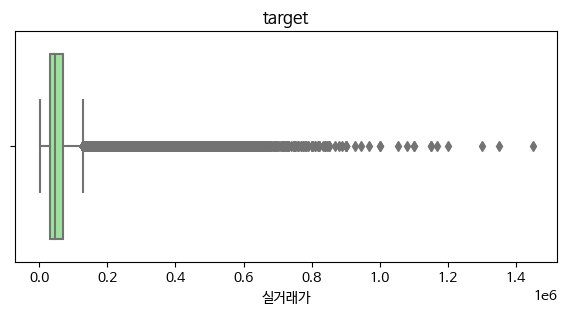

In [69]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt, x = 'target', color='lightgreen')
plt.title('target')
plt.xlabel('실거래가')
plt.show()

### TODO